# APPM 4720 Applied Deep Learning
## Progress Report 03 - Knowledge Distillation
## Sabrina Liu, October 1, 2021
The objectives of this progress report are:
1. to understand the knowledge distillation process in depth through breaking down the logical components.
2. to obtain solid mathematical explanations about the softmax distribution and cross-entropy loss gradient calculation.
3. to practice using the ```tensorflow``` library in order to build customized forward-loss-backpropagation processes. 
4. to practice using the ```cifar100``` dataset and practice using top 5 categorical accuracy metric. 

Tutorials and References:
* (Paper) Distilling the Knowledge in a Neural Network. https://arxiv.org/abs/1503.02531
* (Code Example) Knowledge Distillation https://keras.io/examples/vision/knowledge_distillation/
* Cross Entropy https://en.wikipedia.org/wiki/Cross_entropy
* Kullback–Leibler Divergence https://en.wikipedia.org/wiki/Kullback-Leibler_divergence

#### Knowledge Distillation
The technique of **knowledge distillation** is to transfer the knowledge already learned from large **cumbersome model** to small **distilled model** (for easier deployment) by training the small model on a **transfer set**. During the training, we apply a **temperature** $T$ hyper-parameter to scale the **softmax distribution** 
$$q_i = \frac{\exp(z_i/T)}{\sum_{k}\exp(z_k/T)}$$ such that
> * when $T=1$, we get a **probability distribution** where the output logits add up to 1, allowing the class label with the top probability to stand out while suppressing all other classes.
> * when $T>1$, we get a **softened distribution** (more uniform), amplifying the values on the classes with lower probabilities, therefore preserving information about the mistakes that could have been made in the original cumbersome model. 

A high temperature of our choise $(T>1)$ is used to train the **cumbersome model**. Consequently, the **transfer set** contains prediction probability vectors that are floating points, instead of typical one-hot vectors, which is used as the **soft traget** to train the **distilled model**. In other words, instead of forcing the distilled model to converge to the ground truth, we want it to converge to the prediction distribution given by the cumbersome model. 

#### Temperature and Logit Distribution
We are interested to see the output distribution from softmax in response to different choices of temperature $T$. Below we plot out the softmax function applied on the same series of sorted, uniformly distributed input data $x$ respectively with $T=1,2,3,4$. It can be observed that with lower $T$, one class will dominate and the curve is flattened as $T$ becomes higher. 

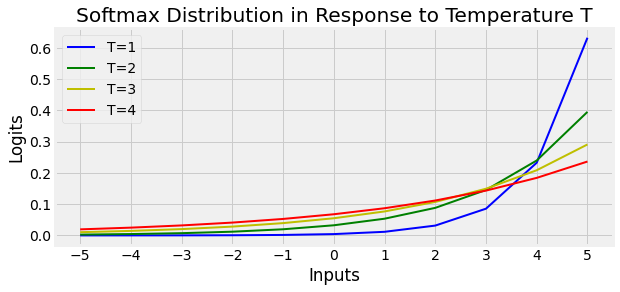

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.style.use(['fivethirtyeight'])

def scaled_softmax(x, T=1):
    return np.exp(x / T) / sum(np.exp(x / T))

x = np.arange(-5,6,step=1)

colors = ['w','b','g','y','r']

for T in range(1, 5):
    y = scaled_softmax(x, T=T)
    _ = plt.plot(x, y, color=colors[T], linewidth=2, label=f"T={T}")

plt.xticks(x)
plt.xlabel('Inputs')
plt.ylabel('Logits')
plt.title('Softmax Distribution in Response to Temperature T')
plt.legend()
plt.show()

#### Distillation Loss Function
We use **cross-entropy loss** for the classification problem as usual. The cross-entropy of the true (target) distribution $p$ relative to a estimated distribution $q$ over a given set is defined in [WikiPedia](https://en.wikipedia.org/wiki/Cross_entropy) as 
$$H(p,q) = -\mathbb{E}_p[\log{q}]$$

When used as a cost function over a discrete set with targets $p$ and predictions $q$, we can write cross-entropy as
$$C=-\sum_{j=1}^{\text{N_SAMPLES}}p_j\log{q_j}$$

where $N$ is the total number of samples and $q$ is **scaled softmax** distribution with temperature $T$:
$$q_i = \frac{\exp(z_i/T)}{\sum_{k=1}^{\text{N_CLASSES}}\exp(z_k/T)}$$



Calculating the **cross-entropy gradient** with respect to learned logit $z_i$:

$$\begin{align}
\frac{\partial C}{\partial z_i} 
& = \frac{\partial}{\partial z_i}\left[-\sum_{j}p_j\log{q_j}\right] 
  = -\sum_{j}p_j \frac{\partial}{\partial z_i}\log{q_j} \\
& = -\sum_{j\neq i}p_j \frac{\partial}{\partial z_i}\log{q_j} 
    -\sum_{j =   i}p_j \frac{\partial}{\partial z_i}\log{q_j} \\
& = -\sum_{j\neq i}p_j \frac{\partial}{\partial z_i}\log{q_j} 
    -p_i \frac{\partial}{\partial z_i}\log{q_i} \\
& = -\sum_{j\neq i}p_j \frac{1}{q_j} \frac{\partial}{\partial z_i} q_j
    -p_i \frac{1}{q_i} \frac{\partial}{\partial z_i} q_i 
\end{align}$$

Calculating $\displaystyle\frac{\partial}{\partial z_i} q_j$ and $\displaystyle\frac{\partial}{\partial z_i} q_i$ separately below:

$$\begin{align}
\frac{\partial}{\partial z_i} q_j
& = \frac{\partial}{\partial z_i} 
    \left[\frac{\exp(z_j/T)}{\sum_{k}\exp(z_k/T)}\right] \\
& = \exp(z_j/T)\frac{\partial}{\partial z_i}
  \left[\sum_{k}\exp(z_k/T)\right]^{-1} \\
& = \exp(z_j/T) \cdot \frac{1}{T}\exp(z_i/T) \cdot 
    -\left[\sum_{k}\exp(z_k/T)\right]^{-2} \\
& = -\frac{1}{T} q_j \cdot q_i \\
\frac{\partial}{\partial z_i} q_i
& = \frac{\partial}{\partial z_i} 
    \left[\frac{\exp(z_i/T)}{\sum_{k}\exp(z_k/T)}\right] \\
& = \frac{\partial}{\partial z_i}
    \left[\exp(z_i/T)\cdot\left(\sum_{k}\exp(z_k/T)\right)^{-1}\right] \\
& = \frac{1}{T} \exp(z_i/T)\cdot\left(\sum_{k}\exp(z_k/T)\right)^{-1}
  - \exp(z_i/T) \cdot \frac{1}{T}\exp(z_i/T) 
  \cdot \left[\sum_{k}\exp(z_k/T)\right]^{-2} \\
& = \frac{1}{T} (q_i - q_i^2)
\end{align}$$

Therefore we have

$$\begin{align}
\frac{\partial C}{\partial z_i} 
& = \sum_{j\neq i}p_j \frac{1}{q_j} \frac{1}{T} q_j \cdot q_i
  - p_i \frac{1}{q_i} \frac{1}{T} (q_i - q_i^2) \\
& = \frac{1}{T}\sum_{j\neq i} p_j \cdot q_i - \frac{1}{T}(p_i - p_i\cdot q_i) \\
& = \frac{1}{T}[q_i \underbrace{\sum_{j}p_j}_{=1} - p_i ] \\ 
\implies \frac{\partial C}{\partial z_i} 
& = \frac{1}{T}(q_i - p_i) 
  = \frac{1}{T} \left(\frac{\exp(z_i/T)}{\sum_j\exp(z_j/T)}-\frac{\exp(v_i/T)}{\sum_j\exp(v_j/T)}\right) 
\end{align}$$

#### Weighted Average
The above cross-entory loss provides a way to match the logits of the distilled model to those of the cumbersome model. The authors mentioned that a better method is to use a **weighted average** of two different objective functions:
> 1. distillation cost: the cross-entropy cost with the soft targets computed using the same high temperature, as explained above. 
> 2. ground-truth cost: the cross-entropy cost with the ground truth labels at a temperature of 1. 

Both cost functions share the same logits during optimization. We can use another hyper-parameter $\alpha$ to control the weights distributed between the two losses. $$\mathcal{L} = 
-\alpha \sum_{j=1}y_j\log{q_j} -(1-\alpha) \sum_{j=1}p_j\log{q_j} $$
Adding the ground truth allows the distilled model to adapt to new data. Additionally, the soft targets serve as a **regularization** mechanism to the distilled model as it contains more general information that might not be learned from new data. 

---

#### Import Dependencies

In [2]:
import tensorflow as tf
import keras
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import add
from keras.layers import LeakyReLU
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Softmax
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.losses import SparseCategoricalCrossentropy
from keras.losses import CategoricalCrossentropy
from keras.losses import KLDivergence
from tensorflow.keras.optimizers import Adam
from keras.metrics import CategoricalAccuracy
from keras.metrics import TopKCategoricalAccuracy

#### Construct ```Distiller()``` Class
In order to construct a Python class to implement the above knowledge distillation algrotihm, we need to consider the below aspects:
> * architecture of the cumbersome model (also called the **teacher** below)
> * architecture of the distilled model (also called the **student** below)
> * expression of the cross-entropy loss with soft targets (first apply softmax)
> * expression of the cross-entropy loss with ground truth (first apply softmax)
> * weights of the two cost functions $\alpha$ and $1-\alpha$
> * softmax scalar temperature $T$

Documentation:
* ```training=False``` for transfer learning https://www.tensorflow.org/api_docs/python/tf/keras/Model
* ```tf.GradientTape()``` https://www.tensorflow.org/api_docs/python/tf/GradientTape
* ```optimizers.apply_gradients()```https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients
* ```compiled_metrics.update_state``` https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric#update_state

In [3]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()    # initialze as keras.Model
        self.teacher = teacher    # the cumbersome model
        self.student = student    # the distilled model

    def build(input_shape):
        super().build(input_shape)

    def compile(
        self,
        optimizer,                # argument overloading
        metrics,                  # argument overloading
        student_loss_fn,          # cross-entropy with ground truth
        distill_loss_fn,          # cross-entrory with soft targets
        alpha=0.1,                # weight on the student loss
        temperature=3,            # softmax scalar
    ):
        """ Configure the knowledge distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distill_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distill_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distill_loss_fn = distill_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x_true, y_true = data    #y_i: one-hot

        # Forward pass of teacher
        # use teacher logits as soft targets and do not update
        y_soft = self.teacher(x_true, training=False)    # v_i: logits

        with tf.GradientTape() as tape:
            # Forward pass of student
            y_pred = self.student(x_true, training=True)    # z_i: logits

            # compute student loss under temperature = 1
            student_loss = self.student_loss_fn(y_true, y_pred)
            # compute distill loss under temperature > 1
            distill_loss = self.distill_loss_fn(
                tf.nn.softmax(y_soft / self.temperature, axis=1),    # p_i
                tf.nn.softmax(y_pred / self.temperature, axis=1),    # q_i
            )
            # calculate weighted average of both as the final loss
            loss = self.alpha * student_loss + (1 - self.alpha) * distill_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y_true, y_pred)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distill_loss": distill_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

#### Import Dataset

In [4]:
from keras.datasets import cifar100 as dataset
(x_train, y_train), (x_test, y_test) = dataset.load_data()

x_train = np.reshape(x_train, (-1, 32, 32, 3)).astype('float32') / 255.
x_test = np.reshape(x_test, (-1, 32, 32, 3)).astype('float32') / 255.

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

INPUT_SHAPE = x_train.shape[1:]
N_CLASSES = y_train.shape[-1]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 100), (10000, 100))

#### Build the Cumbersome Model (Teacher)
The below cumbersome (teacher) model is adapted from the one in the code example, but with a few changes:
1. changed convolutional layer kernel initializer to Kaiming Normal Initialization.
2. changed Leaky ReLU activation to ReLU activation.
3. added Batch Normalization after each convolution activation. 
4. added more convolutional blocks
5. kept dimensions in convolutional layers and used max pooling for dimension reduction

In [5]:
def build_teacher_model():
    K.clear_session()

    model = keras.Sequential(
        [
            keras.Input(shape=INPUT_SHAPE),

            Conv2D(64, (3, 3), strides=1, 
                padding="same", kernel_initializer='he_normal'),
            Activation('relu'),
            BatchNormalization(axis=3),

            Conv2D(128, (3, 3), strides=1, 
                padding="same", kernel_initializer='he_normal'),
            Activation('relu'),
            BatchNormalization(axis=3),
            MaxPooling2D(pool_size=(2, 2), padding="same"),

            Conv2D(256, (3, 3), strides=1, 
                padding="same", kernel_initializer='he_normal'),
            Activation('relu'),
            BatchNormalization(axis=3),
            MaxPooling2D(pool_size=(2, 2), padding="same"),
            
            Conv2D(512, (3, 3), strides=1, 
            padding="same", kernel_initializer='he_normal'),
            Activation('relu'),
            BatchNormalization(axis=3),
        
            Flatten(),
            Dense(N_CLASSES),
            # leave out softmax activation to preserve logits
        ],
        name="teacher",
    )
    return model

teacher = build_teacher_model()
teacher.summary()

Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0   

#### Build the Distilled Model (Student)
The distilled (student) model is a lot leaner than the teacher model. It uses much fewer shared parameters in convolutional layers, and resulted in ~200k trainable parameters, compared to over 4.8 million trainable parameters in the teacher model, a 24x memory saving. Batch Normalization is also removed in the student model to speed up training and deployment.

In [6]:
def build_student_model():
    K.clear_session()

    model = keras.Sequential(
        [
            keras.Input(shape=INPUT_SHAPE),
            Conv2D(16, (3, 3), strides=2, 
                padding="same", kernel_initializer='he_normal'),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
            Conv2D(32, (3, 3), strides=2, 
                padding="same", kernel_initializer='he_normal'),
            Activation('relu'),
            Flatten(),
            Dense(N_CLASSES),
            # leave out softmax activation to preserve logits
        ],
        name="student",
    )
    return model

student = build_student_model()
student.summary()

Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               2049

#### Set up Training Protocol
The code example used ```SparseCategoricalCrossEntropy``` loss function to direcly calculate loss from labels, here we use ```CategoricalCrossEntropy``` loss function to calulate loss with logits and one-hot vectors. For inference, logits and their probability distribution from softmax function produce the same predictions based on the ```argmax``` operation. Additionally, we want to evaluate both top 1 and top 5 categorical accuracies.

In [7]:
BATCH_SIZE = 32
N_EPOCHS = 100
N_WORKERS = 100

compile_dict = dict(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=[CategoricalAccuracy(name='top1_acc'), 
             TopKCategoricalAccuracy(k=5, name='top5_acc')],
)

fit_dict = dict(
    validation_split=0.2,
    shuffle=True,
    batch_size=BATCH_SIZE * N_WORKERS, 
    epochs=N_EPOCHS, 
    verbose=0,
    workers=N_WORKERS, 
    use_multiprocessing=True
)

model_history = {}

#### Train the Teacher


In [8]:
%%time

teacher.compile(**compile_dict)
history = teacher.fit(x_train, y_train, **fit_dict)
model_history['teacher'] = history.history

_, test_top1_acc, test_top5_acc = teacher.evaluate(x_test, y_test)
model_history['teacher']['test_top1_acc'] = test_top1_acc
model_history['teacher']['test_top5_acc'] = test_top5_acc

313/313 [==============================] - 1s 4ms/step - loss: 3.1006 - top1_acc: 0.4244 - top5_acc: 0.6918
CPU times: user 7min 43s, sys: 10.6 s, total: 7min 53s
Wall time: 9min 58s


#### Train the Student from Scratch
For comparison, we train the student model separately from scratch on the same training data to observe the effectiveness of the distillation process. 

In [9]:
%%time

student.compile(**compile_dict)
history = student.fit(x_train, y_train, **fit_dict)
model_history['student'] = history.history

_, test_top1_acc, test_top5_acc = student.evaluate(x_test, y_test)
model_history['student']['test_top1_acc'] = test_top1_acc
model_history['student']['test_top5_acc'] = test_top5_acc


313/313 [==============================] - 1s 2ms/step - loss: 3.6606 - top1_acc: 0.3103 - top5_acc: 0.5868
CPU times: user 53.2 s, sys: 1.64 s, total: 54.9 s
Wall time: 41.9 s


#### Hyper-Parameter Gird Search
Below we design a small grid search for hyper-parameter tuning with three options for T and four options for alpha. 

In [10]:
option_T = [2,3,4]
option_alpha = [.1, .2, .3, .4]
search_grid = []

for T in option_T:
    for alpha in option_alpha:
        search_grid.append(dict(T=T, alpha=alpha))

search_grid

[{'T': 2, 'alpha': 0.1},
 {'T': 2, 'alpha': 0.2},
 {'T': 2, 'alpha': 0.3},
 {'T': 2, 'alpha': 0.4},
 {'T': 3, 'alpha': 0.1},
 {'T': 3, 'alpha': 0.2},
 {'T': 3, 'alpha': 0.3},
 {'T': 3, 'alpha': 0.4},
 {'T': 4, 'alpha': 0.1},
 {'T': 4, 'alpha': 0.2},
 {'T': 4, 'alpha': 0.3},
 {'T': 4, 'alpha': 0.4}]

#### Train the Student with Knowledge Distillation
The code example implemented the disllation loss with ```KLDivergence``` function, which applies to the situation when the teacher model is a large ensemble generalist-specialist model. For our training, we use ```CategoricalCrossentropy``` to calculate the distillation loss from two sets of logits after applying softmax function, to be consistent with the mathematical calculations above. 

In [11]:
%%time

for i in range(len(search_grid)):

    # initiate hyper-parameters
    hyper_params = search_grid[i]

    # initiate a untrained student model each time
    # teacher is already trained, simply use the output logits
    distiller = Distiller(teacher=teacher, student=build_student_model())
    
    distiller.compile(
        optimizer=Adam(),
        metrics=[CategoricalAccuracy(name='top1_acc'), 
                 TopKCategoricalAccuracy(k=5, name='top5_acc')],
        # in student loss, the prediction vectors are pre-softmax logits
        student_loss_fn=CategoricalCrossentropy(from_logits=True),
        # in distill loss, softmax (higher T) has been applied to the logits
        distill_loss_fn=CategoricalCrossentropy(from_logits=False),
        alpha=hyper_params['alpha'],
        temperature=hyper_params['T']
    )

    # Distill teacher to student
    history = distiller.fit(x_train, y_train, **fit_dict)
    model_name = f"distiller_{str(i).zfill(2)}"
    model_history[model_name] = history.history
    
    test_top1_acc, test_top5_acc, _ = distiller.evaluate(x_test, y_test)
    model_history[model_name]['test_top1_acc'] = test_top1_acc
    model_history[model_name]['test_top5_acc'] = test_top5_acc


313/313 [==============================] - 1s 3ms/step - top1_acc: 0.3284 - top5_acc: 0.6199 - student_loss: 3.2419
CPU times: user 14min 11s, sys: 37.2 s, total: 14min 48s
Wall time: 36min 58s


In [12]:
# create directory to save results if not exist
import os
if not os.path.exists('./models'):
    os.mkdir('./models')

# when finish, write the model history as a binary file
import pickle
with open('./models/model_history.pkl', 'wb') as pickle_file:
    pickle.dump(model_history, pickle_file)

#### Evaluate Performence

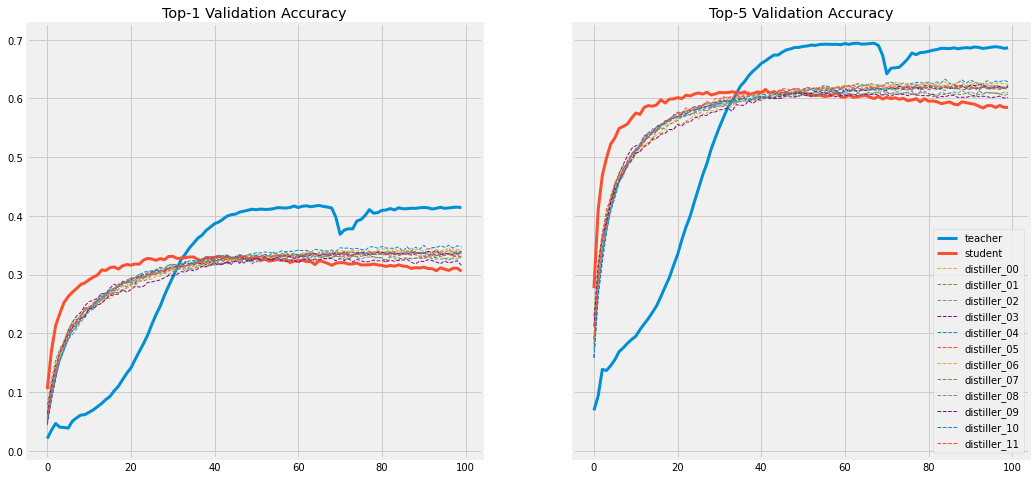

In [13]:
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)

colors = []
for model in model_history:
    history = model_history[model]
    p = axes[0].plot(history['val_top1_acc'], label=model,
                     linewidth=1 if 'distill' in model else 3,
                     linestyle='--' if 'distill' in model else '-')
    _ = axes[1].plot(history['val_top5_acc'], label=model,
                     linewidth=1 if 'distill' in model else 3,
                     linestyle='--' if 'distill' in model else '-')
    c = p[0].get_color()
    colors.append(c)

axes[0].set(title='Top-1 Validation Accuracy')
axes[1].set(title='Top-5 Validation Accuracy')

plt.legend()
plt.show()

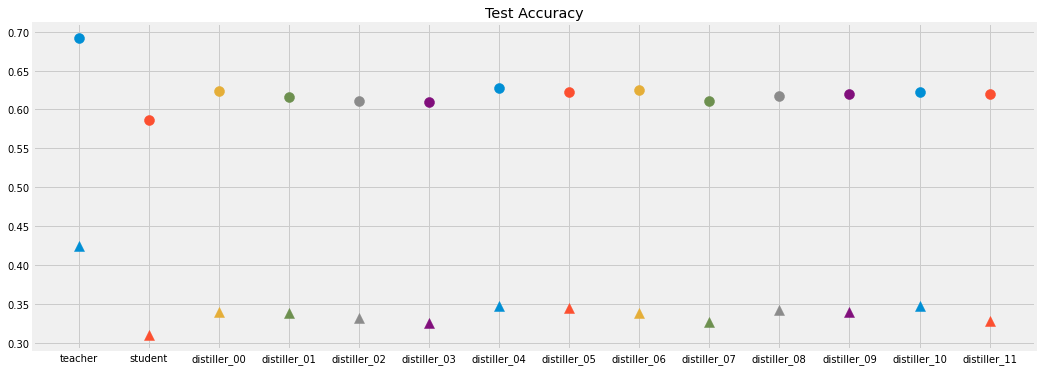

In [14]:
plt.figure(figsize=(16,6))

top1_test, top5_test = [], []
for i, v in enumerate(model_history):
    top1_test.append(model_history[v]['test_top1_acc'])
    top5_test.append(model_history[v]['test_top5_acc'])

for i, v in enumerate(zip(top1_test, colors)):
    _ = plt.scatter(i, v[0], marker='^', s=100, c=v[1])

for i, v in enumerate(zip(top5_test, colors)):
    _ = plt.scatter(i, v[0], marker='o', s=100, c=v[1])

x = list(range(i+1))
labels = list(model_history.keys())
plt.xticks(x, labels, rotation=0)
plt.title('Test Accuracy')
plt.show()

In [15]:
idx = np.argmax(top5_test[2:])    # do not count teacher and student
print("Hyper-parameters for best test accuracy: distiller_{}, {}".format(
    str(idx).zfill(2),
    search_grid[idx]
))

Hyper-parameters for best test accuracy: distiller_04, {'T': 3, 'alpha': 0.1}


#### Observations
* Interestingly, even though the learning curve of the teacher model was a little slow at the beginning, it outperformed both the student model (trained from scratch) and the distilled models in the long run.
* The distilled models outperformed the student model in general. 
* It was determined the best distillation performance is achieved with temperature T=3 and weights on student loss alpha=0.1, when the distiller outperforms the student model alone by large. 